## Analysis of a Car Sell Dataset Part 2

There are two goals in the second analysis task: (1), train linear regression models to predict the selling prices of cars; (2) assess the data ethics issues. There are *7* questions in this portfolio. 

The first goal involves a standard Data Science workflow: exploring data, building models, making predictions, and evaluating results. In this task, we will explore the impacts of feature selections and different sizes of training/testing data on the model performance. We will use another cleaned car_sells sub-dataset that **is different from** the one in “Analysis of a Car Sell Dataset” task 1. This goal covers Questions *1-6*. 

Question *7* is about data ethics issue.

your_name = "Fraser Howard"  
your_student_id = "47805145"


In [536]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

### Q1: Import Cleaned Car Sell Dataset
The csv file named 'car_sells_clean_data.csv' is provided. You may need to use the Pandas method, i.e., `read_csv`, for reading it. After that, please print out its total length.

In [538]:
cars = pd.read_csv('car_sells_clean_data.csv')
print("Total Length of Cars:" , cars.shape)

Total Length of Cars: (3657, 8)


### Q2: Explore the Dataset

* Use the methods, i.e., `head()` and `info()`, to have a rough picture about the data, e.g., how many columns, and the data types of each column.
* As our goal is to predict cars' selling prices given other columns, please get the correlations between year/km_driven/seller_type/fuel/owner and selling_price by using the `corr()` method.
* To get the correlations between different features, you may need to first convert the categorical features (i.e., seller_type and owner) into numerial values. For doing this, you may need to import `OrdinalEncoder` from `sklearn.preprocessing` (refer to the useful exmaples [here](https://pbpython.com/categorical-encoding.html))
* Please provide ___necessary explanations/analysis___ on the correlations, and figure out which are the ___most___ and ___least___ corrleated features regarding selling_price. Try to ___discuss___ how the correlation will affect the final prediction results, if we use these features to train a regression model for selling_price prediction. In what follows, we will conduct experiments to verify your hypothesis.

In [540]:
#Q2 Part 1: Display of Cars Data
print(cars.head())
print(cars.info())

print("Cars contains 8 columns with the Data types of each, listed as Dtype")

                       name    year  selling_price  km_driven    fuel  \
0             Maruti 800 AC  2007.0          60000      70000  Petrol   
1  Maruti Wagon R LXI Minor  2007.0         135000      50000  Petrol   
2      Hyundai Verna 1.6 SX  2012.0         600000     100000  Diesel   
3    Datsun RediGO T Option  2017.0         250000      46000  Petrol   
4     Honda Amaze VX i-DTEC  2014.0         450000     141000  Diesel   

  seller_type transmission         owner  
0  Individual       Manual   First Owner  
1  Individual       Manual   First Owner  
2  Individual       Manual   First Owner  
3  Individual       Manual   First Owner  
4  Individual       Manual  Second Owner  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3657 entries, 0 to 3656
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           3657 non-null   object 
 1   year           3657 non-null   float64
 2   selling_price  3

In [541]:
#Q2 Part 2: Converting the Categorical Data into Numerical Data and Printing the Correlations of Columns to Selling Price.

#Import Libraries
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()



#Select only object columns to convert.
#Named num_cars as each car column will be converted to a numerical value.
num_cars = cars.select_dtypes(include=['object']).copy() 

#convert all object columns into numerical values
for column in num_cars.columns:
    num_cars[column + "_code"] = ordinal_encoder.fit_transform(num_cars[[column]]).ravel()
    
#Add the extra non-categorical columns to the transformed data
num_cars['year']=cars['year']
num_cars['selling_price']=cars['selling_price']
num_cars['km_driven']=cars['km_driven']

#Calculate the correlation between each column and the selling price
correlations = num_cars[['year', 'km_driven', 'seller_type_code', 'fuel_code', 'owner_code', 'selling_price']].corr()
print("The Correlations with the Selling Price:\n", correlations['selling_price'])

The Correlations with the Selling Price:
 year                0.411103
km_driven          -0.177203
seller_type_code   -0.208637
fuel_code          -0.277627
owner_code         -0.205524
selling_price       1.000000
Name: selling_price, dtype: float64


# Q2 Part 3: Necessary Explanations/Analysis of the Correlations and Predictions for Later Regression Models

**The most correlated features to the least correlated features regarding selling price:**
- **selling_price**: 1 (self-correlation)
- **year**: 0.411103
- **km_driven**: -0.177203
- **owner_code**: -0.205524
- **seller_type_code**: -0.208637
- **fuel_code**: -0.277627

### Analysis of Correlations:

- **Year**: The positive correlation with car selling price indicates that more recent years tend to have higher selling prices. This strong correlation suggests that this feature will be useful for later regression models, as it possesses significant predictive power. It should lead to more accurate predictions due to its moderate, positive relationship with selling price.

- **Kilometers Driven**: The negative correlation implies that cars with higher kilometers driven often have lower selling prices. This may be attributed to wear and tear or the depreciation of the asset. While this negative relationship will likely push predictions downward for cars with higher kilometers, its magnitude is not as strong as that of the year.

- **Owner Code**: The negative correlation suggests that cars with more previous owners often have lower selling prices. Buyers may perceive that multiple ownerships expose the cars to greater risks, such as mechanical issues or lower reliability, which diminishes their value. Consequently, the predictions based on this relationship may not be as robust in the dataset compared to the year.

- **Seller Type Code**: The negative correlation indicates that different seller types can negatively affect the selling price. The regression model may predict higher selling prices for cars sold by dealers, while cars sold by individuals may yield lower predictions. However, due to the relatively low correlation, the accuracy of these predictions might be less reliable compared to the year.

- **Fuel Code**: The negative correlation suggests that certain fuel types can decrease a car's selling price. This feature has the strongest negative correlation, indicating a significant influence on the selling price and, consequently, a relatively strong impact on predictions.


### Q3: Split Training and Testing Data
* Machine learning models are trained to help make predictions for the future. Normally, we need to randomly split the dataset into training and testing sets, where we use the training set to train the model, and then leverage the well-trained model to make predictions on the testing set.
* To further investigate whether the size of the training/testing data affects the model performance, please randomly split the data into training and testing sets with different sizes:
    * Case 1: training data containing 10% of the entire data;
    * Case 2: training data containing 90% of the entire data.
* Print the shape of training and testing sets in the two cases.

In [543]:
#Q3 Split Training and Testing Data:
from sklearn.model_selection import train_test_split


#Displaying how to setup the training and testing sets.
X=num_cars[['year','seller_type_code', 'km_driven', 'fuel_code', 'owner_code']]
y=num_cars['selling_price']

X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(X,y,test_size=0.9, random_state=142)
print("Case 1: Training data containing 10% of the entire data :", X_train_10.shape,X_test_10.shape)

X_train_90, X_test_90, y_train_90, y_test_90 = train_test_split(X,y,test_size=0.1, random_state=142)
print("Case 2: Training data containing 90% of the entire data :", X_train_90.shape,X_test_90.shape)


Case 1: Training data containing 10% of the entire data : (365, 5) (3292, 5)
Case 2: Training data containing 90% of the entire data : (3291, 5) (366, 5)


### Q4: Train Linear Regression Models with Feature Selection under Cases 1 & 2
* When training a machine learning model for prediction, we may need to select the most important/correlated input features for more accurate results.
* To investigate whether feature selection affects the model performance, please select two most correlated features and two least correlated features regarding selling_price, respectively.
* Train four linear regression models by following the conditions:
    - (model-a) using the training/testing data in case 1 with two most correlated input features
    - (model-b) using the training/testing data in case 1 with two least correlated input features
    - (model-c) using the training/testing data in case 2 with two most correlated input features
    - (model-d) using the training/testing data in case 2 with two least correlated input features
* By doing this, we can verify the impacts of the size of traing/testing data on the model performance via comparing model-a and model-c (or model-b and model-d); meanwhile the impacts of feature selection can be validated via comparing model-a and model-b (or model-c and model-d).    

In [545]:
#Q4 Training Linear Regression Models for (Model-a):
from sklearn.linear_model import LinearRegression

#Define Features and Variable
X1_most=num_cars[['year']]
y=num_cars['selling_price']

#Split the data into the training and test set
X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(X1_most,y,test_size=0.9, random_state=142)

#Train the model using the training data
model_a = LinearRegression()
model_a.fit(X_train_10,y_train_10)

#Setup the predictions for Q5
predicted_a = model_a.predict(X_test_10)

In [546]:
#Q4 Training Linear Regression Models for (Model-b):
from sklearn.linear_model import LinearRegression

#Define Features and Variable
X1_least=num_cars[['owner_code']]
y=num_cars['selling_price']

#Split the data into the training and test set
X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(X1_least,y,test_size=0.9, random_state=142)

#Train the model using the training data
model_b = LinearRegression()
model_b.fit(X_train_10,y_train_10)

#Setup the predictions for Q5
predicted_b = model_b.predict(X_test_10)

In [547]:
#Q4 Training Linear Regression Models for (Model-c):
from sklearn.linear_model import LinearRegression

#Define Features and Variable
X2_most=num_cars[['year']]
y=num_cars['selling_price']

#Split the data into the training and test set
X_train_90, X_test_90, y_train_90, y_test_90 = train_test_split(X2_most,y,test_size=0.1, random_state=142)

#Train the model using the training data
model_c = LinearRegression()
model_c.fit(X_train_90,y_train_90)

#Setup the predictions for Q5
predicted_c = model_c.predict(X_test_90)

In [548]:
#Q4 Training Linear Regression Models for (Model-d):
from sklearn.linear_model import LinearRegression

#Define Features and Variable
X2_least=num_cars[['owner_code']]
y=num_cars['selling_price']

#Split the data into the training and test set
X_train_90, X_test_90, y_train_90, y_test_90 = train_test_split(X2_least,y,test_size=0.1, random_state=142)

#Train the model using the training data
model_d = LinearRegression()
model_d.fit(X_train_90,y_train_90)

#Setup the predictions for Q5
predicted_d = model_d.predict(X_test_90)




### Q5: Evaluate Models
* Evaluate the performance of the four models with two metrics, including MSE and Root MSE
* Print the results of the four models regarding the two metrics

In [550]:
#Q5 - MSE and RootMSE of the Four Models:
from sklearn.metrics import mean_squared_error, r2_score

#Calculate the MSE and RMSE using the imported libraries. Information sourced from tutorials.

#Model A:
mse_a = mean_squared_error(y_test_10, predicted_a)
rmse_a = (mse_a)**(1/2)
print('Mean Squared Error of Model A = ', mse_a)
print('Root Mean Squared Error of Model A = ', rmse_a)

#Model B:
mse_b = mean_squared_error(y_test_10, predicted_b)
rmse_b = (mse_b)**(1/2)
print('Mean Squared Error of Model B = ', mse_b)
print('Root Mean Squared Error of Model B = ', rmse_b)

#Model C:
mse_c = mean_squared_error(y_test_90, predicted_c)
rmse_c = (mse_c)**(1/2)
print('Mean Squared Error of Model C = ', mse_c)
print('Root Mean Squared Error of Model C = ', rmse_c)

#Model D:
mse_d = mean_squared_error(y_test_90, predicted_d)
rmse_d = (mse_d)**(1/2)
print('Mean Squared Error of Model D = ', mse_d)
print('Root Mean Squared Error of Model D = ', rmse_d)


Mean Squared Error of Model A =  253660959513.10025
Root Mean Squared Error of Model A =  503647.65413243044
Mean Squared Error of Model B =  282081927717.6339
Root Mean Squared Error of Model B =  531113.8557010483
Mean Squared Error of Model C =  207551379883.51544
Root Mean Squared Error of Model C =  455578.0722154167
Mean Squared Error of Model D =  250370196512.05246
Root Mean Squared Error of Model D =  500370.0595679686


# Q5 - Written Evaluation of Each Model:

The Mean Squared Error (MSE) calculates the magnitude of the prediction errors. A lower MSE indicates that the predictions are closer to the actual values, signifying better model performance. 

Comparing the four models, **Model C** emerges as the best performing model, as it has the lowest MSE and Root Mean Squared Error (RMSE), which indicates the most accurate predictions. Despite this, the high MSE across all models suggests a substantial discrepancy between the actual and predicted results, highlighting room for improvement in the predictive capabilities of the models.


### Q6: Visualize, Compare and Analyze the Results
* Visulize the results, and perform ___insightful analysis___ on the obtained results. For better visualization, you may need to carefully set the scale for the y-axis.
* Normally, the model trained with most correlated features and more training data will get better results. Do you obtain the similar observations? If not, please ___explain the possible reasons___.

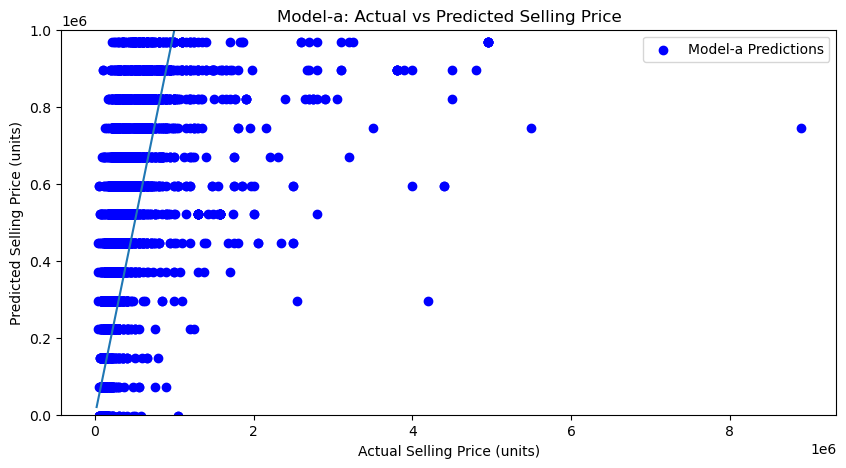

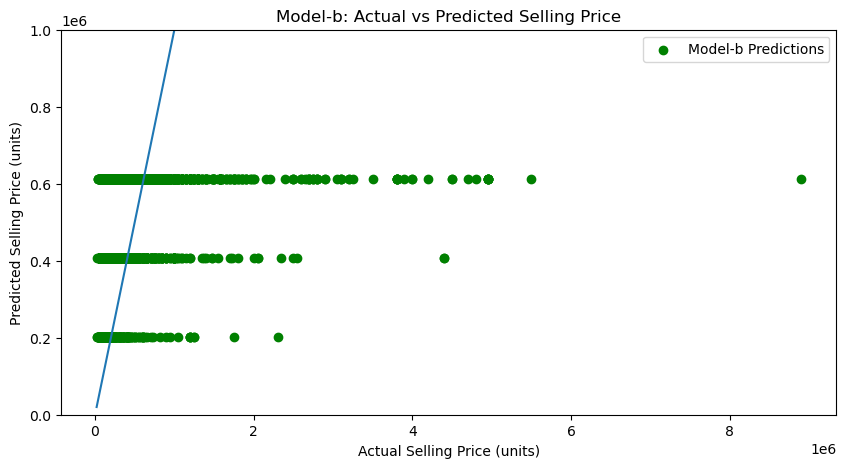

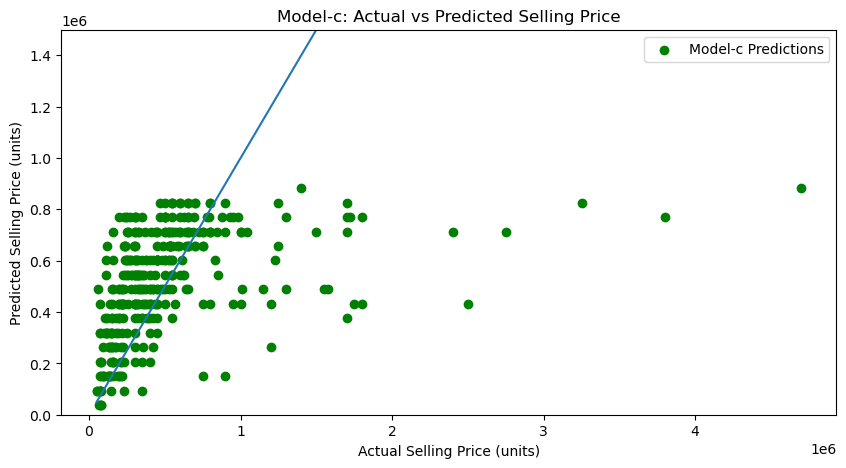

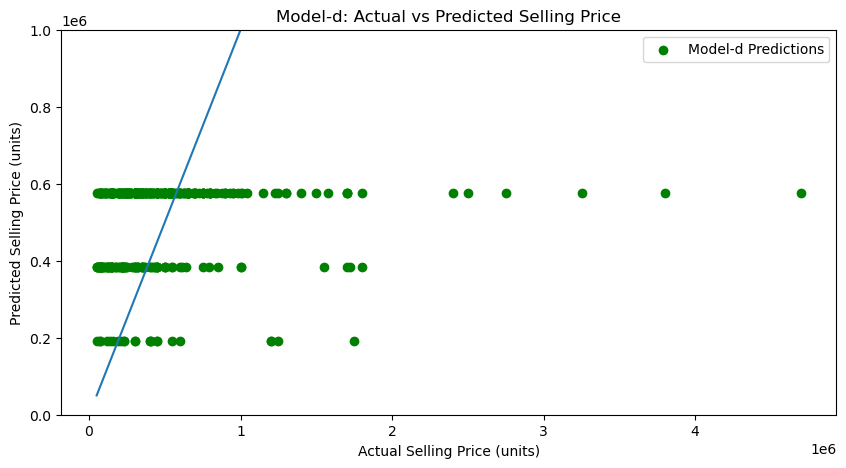

In [552]:
#Q6 Visualise the Results:
import matplotlib.pyplot as plt
import seaborn as sns

#Plot each model using the scatterplot template provided in lectures. 
#With a 'trendline to show a one-to-one correlation, as a comparison.
#Also limits the y-axis between 1 and 1e6, as no data is shown above this. Improves visualisation readbility.
#Units for axis were unknown.

# Plot for Model-a
plt.figure(figsize=(10, 5))
plt.scatter(y_test_10, predicted_a, color='blue', label='Model-a Predictions')
plt.plot([y_test_10.min(), y_test_10.max()], [y_test_10.min(), y_test_10.max()])
plt.xlabel('Actual Selling Price (units)')
plt.ylabel('Predicted Selling Price (units)')
plt.title('Model-a: Actual vs Predicted Selling Price')
plt.legend()
plt.ylim(bottom=0, top=1e6)
plt.show()


# Plot for Model-b
plt.figure(figsize=(10, 5))
plt.scatter(y_test_10, predicted_b, color='green', label='Model-b Predictions')
plt.plot([y_test_10.min(), y_test_10.max()], [y_test_10.min(), y_test_10.max()])
plt.xlabel('Actual Selling Price (units)')
plt.ylabel('Predicted Selling Price (units)')
plt.title('Model-b: Actual vs Predicted Selling Price')
plt.legend()
plt.ylim(bottom=0, top=1e6)
plt.show()

# Plot for Model-c
plt.figure(figsize=(10, 5))
plt.scatter(y_test_90, predicted_c, color='green', label='Model-c Predictions')
plt.plot([y_test_90.min(), y_test_90.max()], [y_test_90.min(), y_test_90.max()])
plt.xlabel('Actual Selling Price (units)')
plt.ylabel('Predicted Selling Price (units)')
plt.title('Model-c: Actual vs Predicted Selling Price')
plt.legend()
plt.ylim(bottom=0, top=1.5e6)
plt.show()

# Plot for Model-d
plt.figure(figsize=(10, 5))
plt.scatter(y_test_90, predicted_d, color='green', label='Model-d Predictions')
plt.plot([y_test_90.min(), y_test_90.max()], [y_test_90.min(), y_test_90.max()])
plt.xlabel('Actual Selling Price (units)')
plt.ylabel('Predicted Selling Price (units)')
plt.title('Model-d: Actual vs Predicted Selling Price')
plt.legend()
plt.ylim(bottom=0, top=1e6)
plt.show()





# Q6 - Visualize the Results and Perform Insightful Analysis

In the graph, the y-axis represents the predicted selling price in an undeclared unit, while the x-axis represents the actual selling price in an undeclared unit. The blue line indicates what a one-to-one relationship would look like between these two variables. However, as discerned from Question 5 and the MSE, the predicted data compared to the actual data is far from this ideal one-to-one line.

As observed across all models, there are numerous outliers for the actual selling price (e.g., values higher than 2 million). These outliers obscure the close relationship among the main clusters and the one-to-one line. For instance, in **Model A**, there is a major cluster that is almost symmetrical to the one-to-one line. However, the presence of outliers affects our MSE and RMSE scores, undermining the relationship between our predictions and the actual selling price.

The graphs with the most correlated data are **Model A** and **Model C**. Typically, models trained with the most correlated features (in this case, **year** and **selling price**) and more training data (90% for **Model C**) yield better results. While the graphs may not visually distinguish these differences, the RMSE indicates that **Model C** is the most accurate, with an RMSE of **455578.0722154167**, which is the lowest among all models. 

Therefore, we can confirm the statement: "Normally, the model trained with the most correlated features and more training data will achieve better results." 


### Q7: Data Science Ethics
*Please read the following examples [Click here to read the example_1.](https://www.vox.com/covid-19-coronavirus-us-response-trump/2020/5/18/21262265/georgia-covid-19-cases-declining-reopening) [Click here to read the example_2.](https://viborc.com/ethics-and-ethical-data-visualization-a-complete-guide/)

*Then view the picture ![My Image](figure_portfolio2.png "This is my image")
Please compose an analysis of 100-200 words that evaluates potential ethical concerns associated with the infographic, detailing the reasons behind these issues.


# Q7 - Data Science Ethics

The information presented is accurate, reliable, and functionally similar. However, the highlighting of the "Total" versus the "Gold" counts completely shifts the emphasis of the data. The ethical concerns include:

1. **Bias in Data Presentation**: The choice of sorting criteria can lead to different interpretations of which country has performed the best. This approach undermines the objectivity of the data and opens the door for subjective debate, reflecting a bias toward certain achievements over others.

2. **Misleading Information**: Individuals may be led to confusion or misinterpretation of the data, which undermines the honesty and accuracy of its collection, as well as the clarity and simplicity of its presentation. This can affect the fairness and objectivity of its output.

3. **Lack of Data Verification**: While sources were included, there is no indication of whether the data has been verified or selectively presented. One source is from seven years after the event and neither is outlined as a primary source for the data.

Overall, the ethical concerns of bias in data presentation, misleading information, and lack of data verification all stem from differing choices of sorting criteria. This ultimately undermines the value of the information presented and may hinder viewers' perceptions of the topic.
